In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, PROJECT_ROOT, LATEX_OUT

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import pandas as pd
import pandas_datareader.fred as fred
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter

from src.plotting import plot_dfs, all_equal
from src.process_data import get_fred_data, ser_adf, get_seasonal_hp, load_data
from src.classes import PolyDetrend
from src.utils import apply_func

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

Load data

In [3]:
from config import fred_dict, recession_dict
df_all = load_data('raw_data.csv', DATA_DIR, fred_dict)
df = df_all.copy()
df.drop(['recs', 'defl'], axis=1, inplace=True)

# sample period
print(f'sample starts: {df.index[0].date()} \nsample ends: {df.index[-1].date()}')

# check for missing intra sample data
pd.DataFrame(df.index - df.index.shift(-1)).describe()

Error occured 'pi_c', file_dict may be incomplete
Error occured 'S', file_dict may be incomplete
sample starts: 1975-01-01 
sample ends: 2022-10-01


,date
count,192
mean,91 days 07:30:00
std,0 days 18:28:49.791775694
min,90 days 00:00:00
25%,91 days 00:00:00
50%,91 days 12:00:00
75%,92 days 00:00:00
max,92 days 00:00:00


#### per capita variables
When using population dynamics, the population data should be smooted with HP 10,000, to account for adjustments around Census data updates, Edge, Gürkaynak, and Kisacikoglu (2013), as in Pfeifer (2021).


In [4]:
_, df['Pop_trend'] = hpfilter(df.Pop, lamb=10000)
df['Pop_trend'] = df.Pop_trend / 100
df.drop('Pop', axis=1, inplace=True)

In [5]:
for col in ['Y', 'Y_p', 'I', 'C', 'Ix', 'Zx', 'L']:
    df[col] = df[col] / df['Pop_trend']

#### quarterly variabels
Transform anual percentage variables into quarterly percentages

In [100]:
for col in ['pi_s', 'pi_c', 'r']:
    df[col] = (1 + df[col]/100) ** (1/4) - 1

### steady state variables

In [101]:
mask = df.index > '1985-01-01'
df_priors = df[~mask].copy()
df = df[mask].copy()

In [102]:
# average quarterly growth rate and std
df_priors['gamma'] = df_priors.Y_p.diff()
γ = df_priors.gamma.mean()
γ_sig = df_priors.gamma.std()

# average inflation
π = df_priors.pi_s.mean()
π_sig = df_priors.pi_s.std()

# real interest rate
df_priors['r_int'] = df_priors.pi_s + df_priors.gamma + df_priors.r
r_int = df_priors.r_int.mean()
r_int_sig = df_priors.r_int.std()


# steady state values
df_priors['beta'] = (1 + 1 / (1 + df_priors['r_int'] / 400))
β = df_priors.beta.mean()
β_sig = df_priors.beta.std()

π = 1 + π / 400
π_sig = π_sig

γ = 1 + γ
γ_sig = γ_sig

In [103]:
print('gamma', γ, γ_sig)
print('pi', π, π_sig)
print('beta', β, β_sig)

gamma 1.016796989187408 0.0051325118384519895
pi 1.0000501628519576 0.007243623547917339
beta 1.9998495918296775 3.274027823932281e-05


''

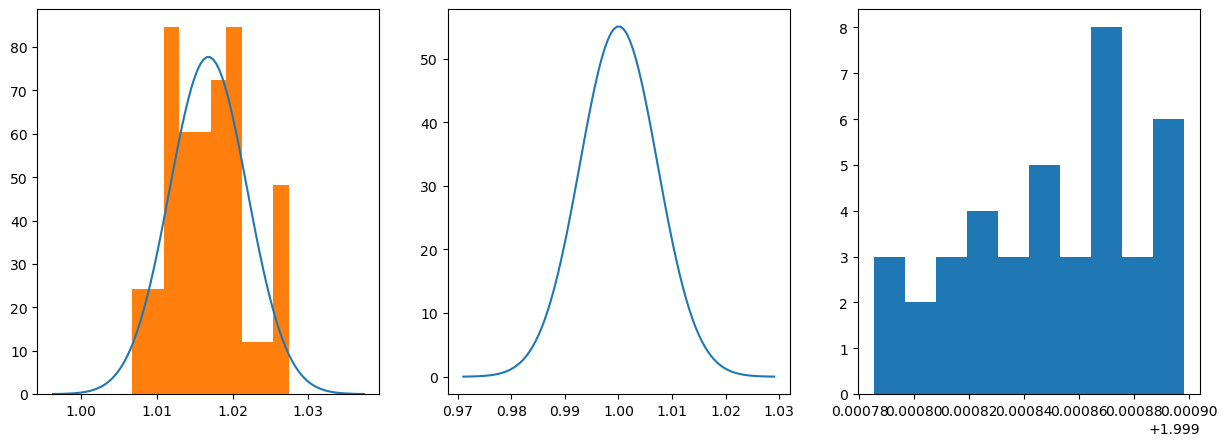

In [104]:
from scipy.stats import norm
interval = 4

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

mask = np.linspace(γ - γ_sig * interval, γ + γ_sig * interval, 100)
ax[0].plot(mask, [norm.pdf(item, γ, γ_sig) for item in mask])
ax[0].hist(df_priors['gamma'] + 1, density=True)

mask = np.linspace(π - π_sig * interval, π + π_sig * interval, 100)
ax[1].plot(mask, [norm.pdf(item, loc=π, scale=π_sig) for item in mask])
# ax[1].hist(df_priors['pi_s'] / 400 + 1 )

mask = np.linspace(β - β_sig * interval, β + β_sig * interval, 100)
# ax[2].plot(mask, [norm.pdf(item, β, β_sig) for item in mask])
ax[2].hist(df_priors['beta'])

;

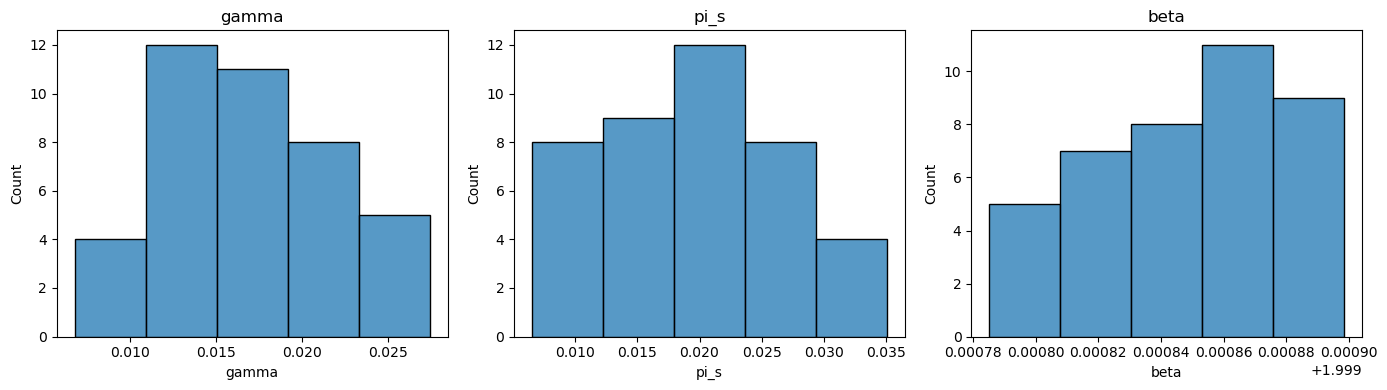

In [105]:
plot_dfs(df_priors[['gamma', 'pi_s', 'beta']], sns.histplot, bins=5);

#### log transform
We are log transforming because the final model will be log-linearized, as such it is describing log deviations in steady state. For the data to match these, logs need to be taken. This excludes all variables that are in percentages already, namely $\bf \pi$ and $r$.

In [106]:
log_cols = ["Y", "S", 'Y_p', "I", "C", "Ix", "Zx", "L", "w"]
for col in log_cols:
    df[col] = apply_func(arr=df[col], func=np.log)

#### train test split

In [107]:
test_size = 5
test_ind = df.iloc[-test_size:,:].index
train_ind = df.iloc[:-test_size,:].index

In [108]:
print(f'test size is: {test_size/len(df) :.2f}%, corresponding to {test_size} lines')
print(f'time between train & test: {(test_ind[0] - train_ind[-1])}')

test size is: 0.03%, corresponding to 5 lines
time between train & test: 92 days 00:00:00


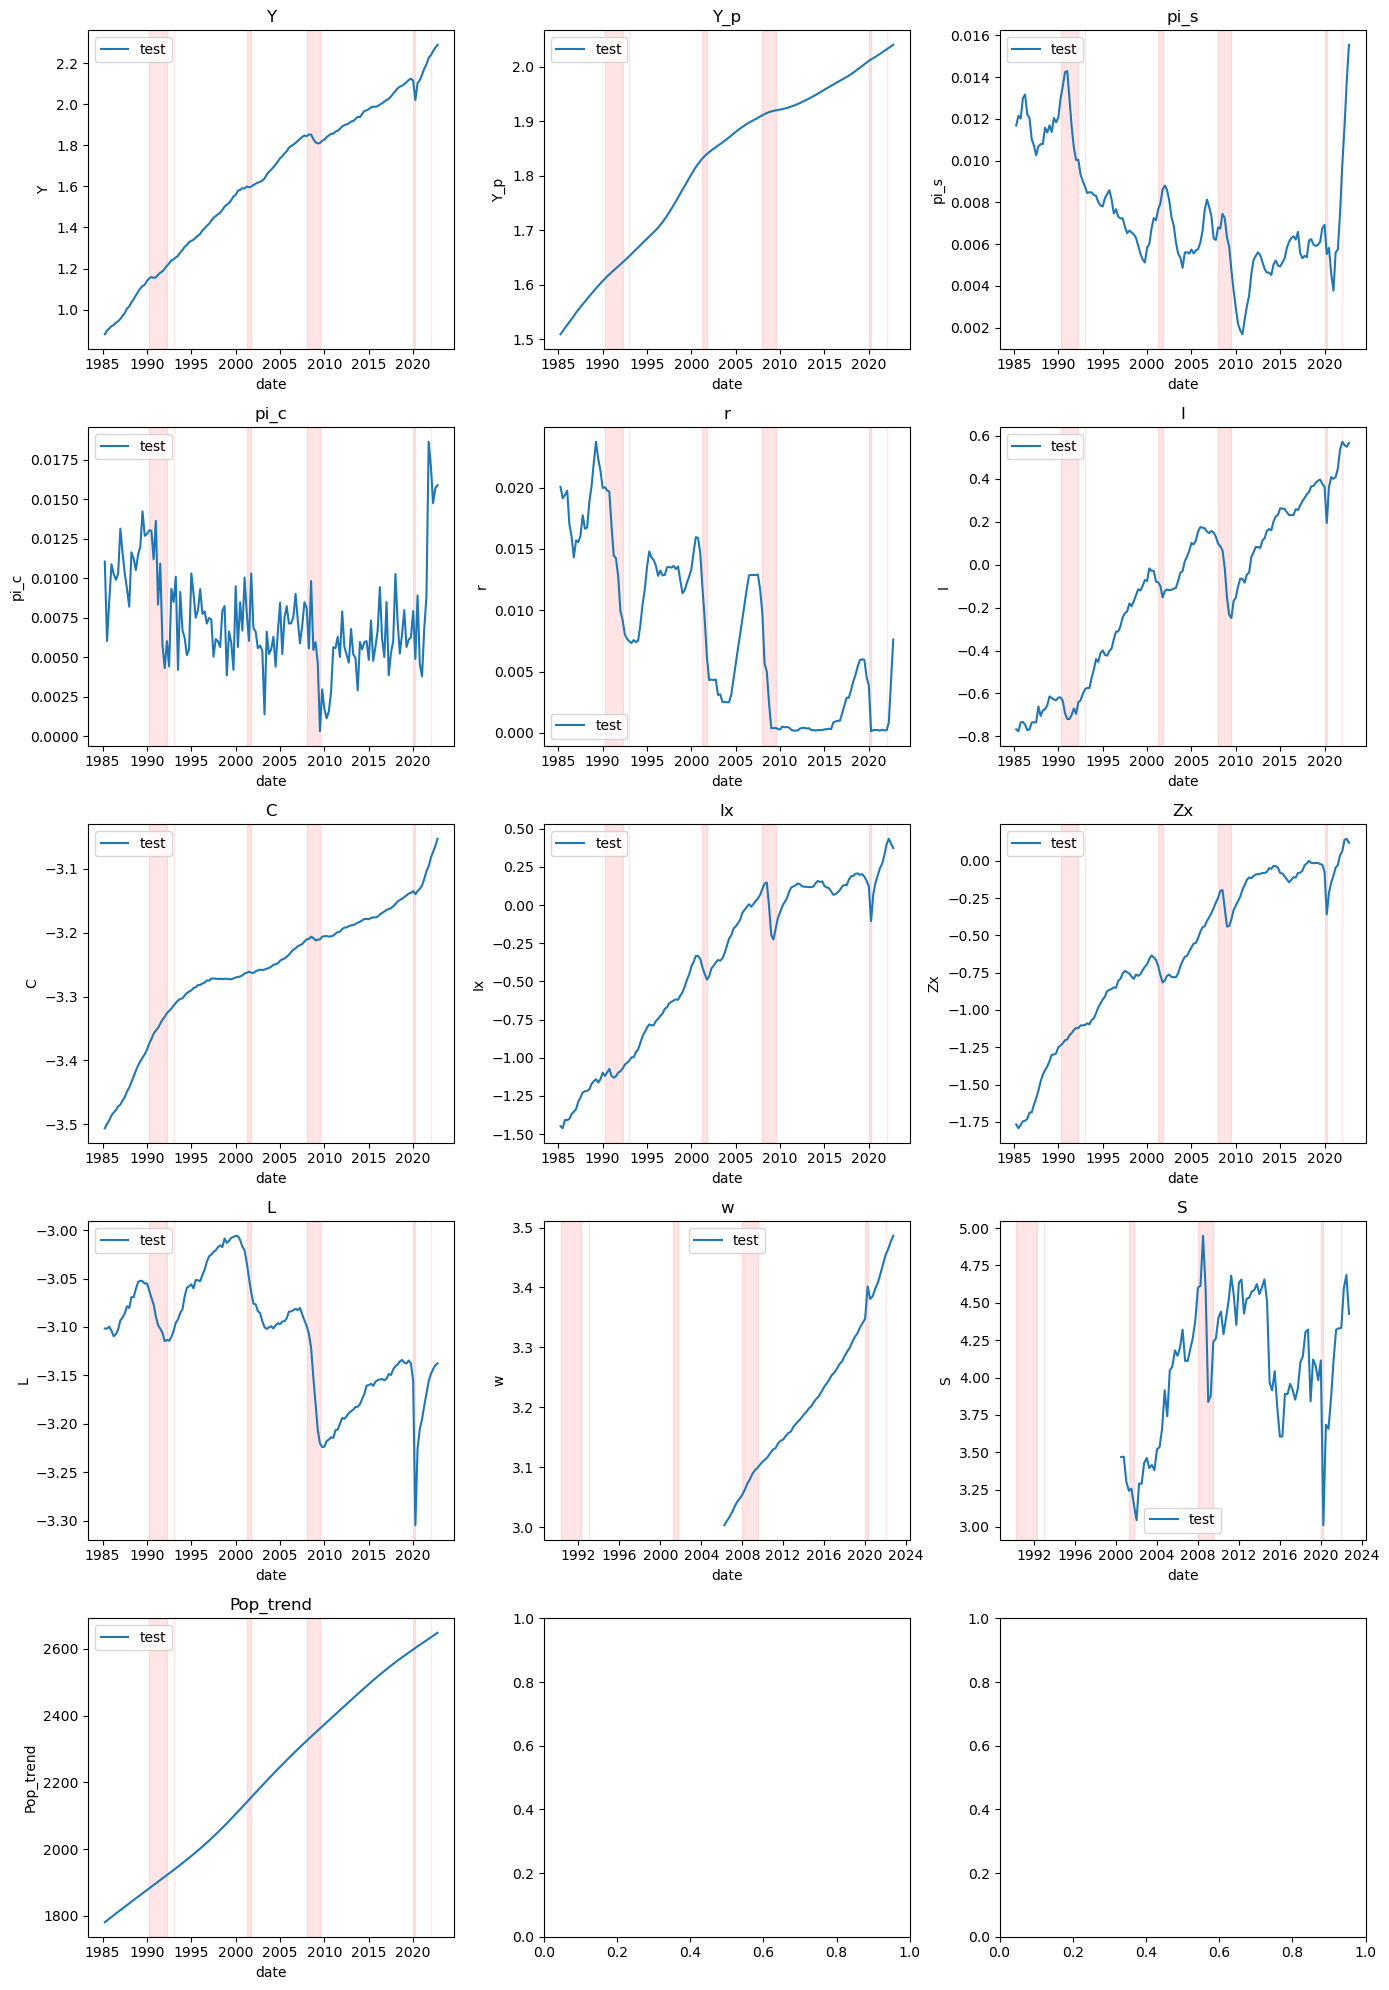

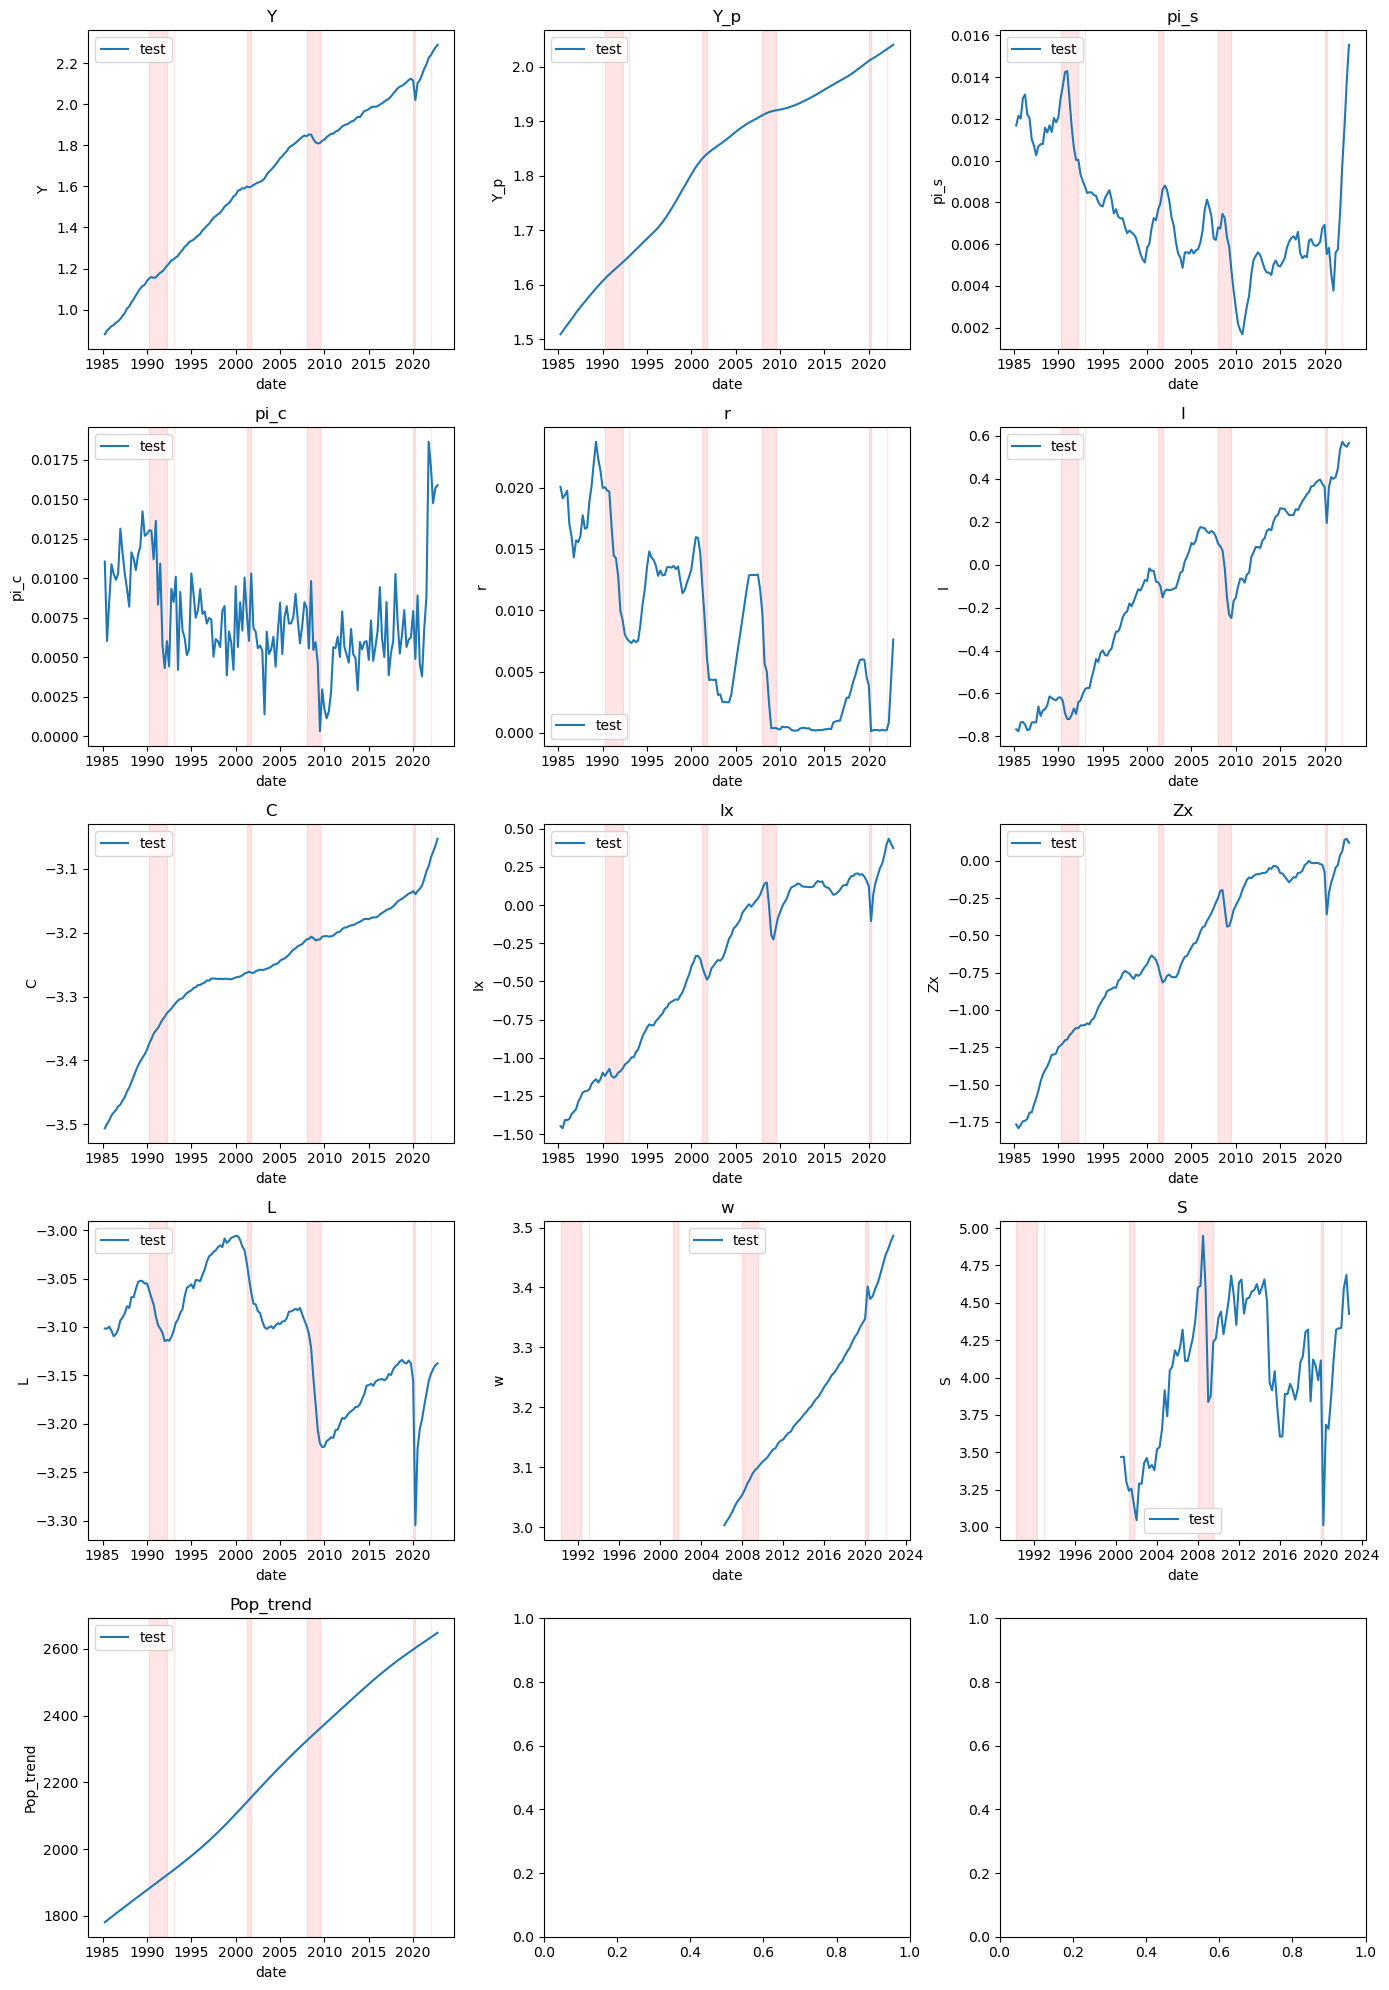

In [111]:
plot_dfs([df], sns.lineplot, fill_arr=recession_dict, legend=['test'])

#### HP filter detrend
The HP filter seperates long-term trend (steady-state) GDP from cycle fluctuations. It outputs decimal percentages, wherefore data that is in percentage terms already needs transformation into decimal percentages.

In [90]:
df_2 = df.copy()

In [91]:
# hp detrend
detrend_cols = ["Y", 'Y_p', "I", "C", "L", "Ix", "Zx", "w"]
for col in detrend_cols:
    ind = df_2[col].dropna().index
    
    cycle, trend = hpfilter(df_2.loc[ind, col], lamb=1600, )
    df_2.loc[ind, col] = cycle
    df_2.loc[ind, f'{col}_trend'] = trend
    
df_2['S'] = df_2['S'] / 10

$\pi$ should be decimal percentage, this what log hp filter outputs

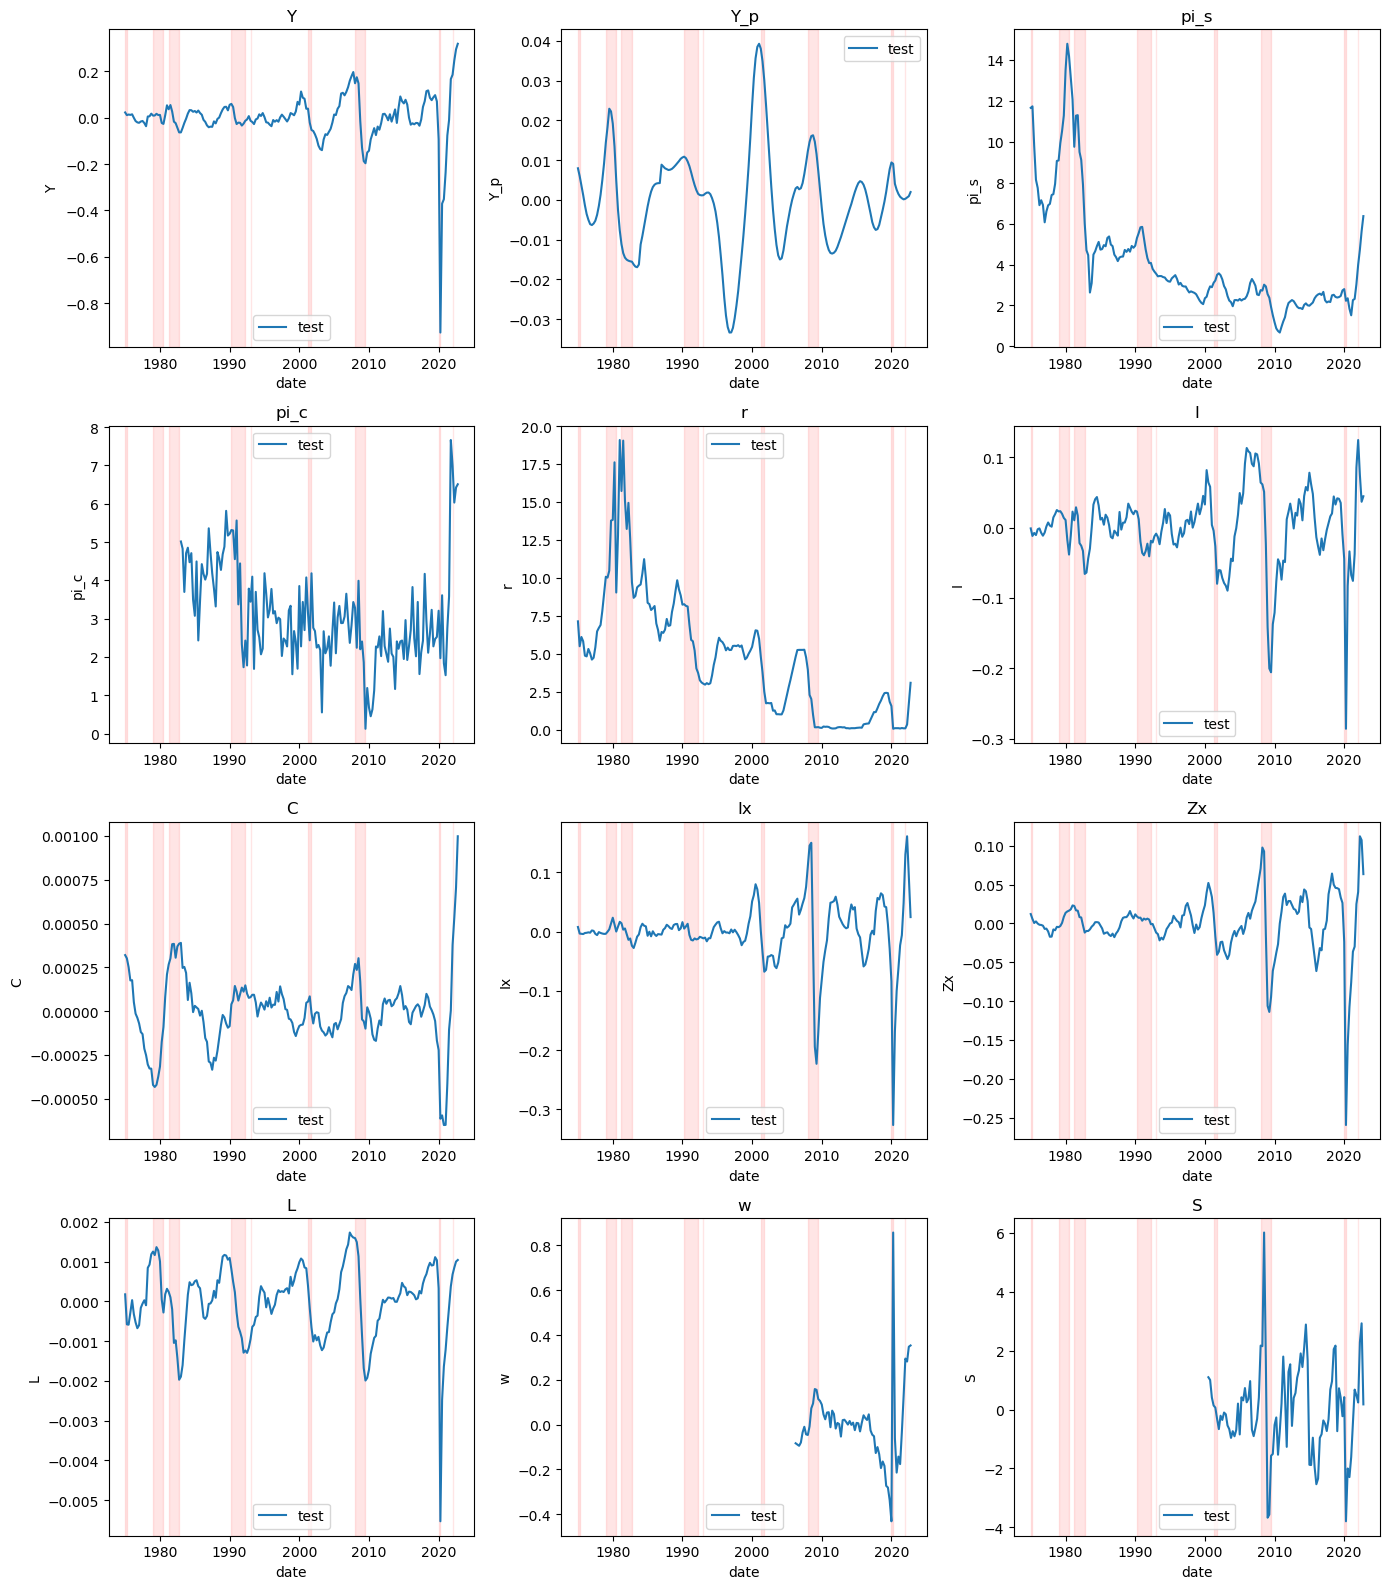

In [94]:
# plot cycle
fig1 = plot_dfs([df_2[[item for item in df_2.columns if 'trend' not in item]]], sns.lineplot, fill_arr=recession_dict, legend=['test'])
# save output
fig1.savefig(os.path.join(LATEX_OUT, f'data_variables_transforemd.png'))

stationarity

In [61]:
# train data hp filter
for col in [item for item in df_2.columns if 'trend' not in item]:
    ser_adf(df_2[col])

Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y --------------------
 p-val: 9.007361690433816e-06,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y_p --------------------
 p-val: 1.2631252912273742e-05,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_s --------------------
 p-val: 0.603681002935593,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_c --------------------
 p-val: 0.0575329463825246,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- r --------------------
 p-val: 0.0777168000251077,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- I --------------------
 p-val: 0.0006688624645013692,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- C --------------------
 p-val: 5.015210002767938e-07,  reject: True


Augmented Dickey-Fuller Test: H0 -> uni

In [62]:
df_2 = df_2[[item for item in df_2.columns if "trend" not in item]].copy()

covariance matrix

In [63]:
import matplotlib.pyplot as plt

In [65]:
# np.cov(df_2[cols].dropna(), bias=False).shape

save data

In [66]:
df_2['is_test'] = list([False] * len(df_2))
df_2.loc[test_ind, 'is_test'] = list([True] * len(test_ind))

In [67]:
df_2.reset_index(names='date').to_csv(os.path.join(DATA_DIR, 'prepro_data.csv'))